In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from freedom.utils.dataset import Data
from freedom.utils.callback import Save

from freedom.neural_nets.hitman import get_hitman
from freedom.neural_nets.transformations import hitman_trafo
import matplotlib.pyplot as plt

In [2]:
data = Data(dirs=[],labels=['x','y','z','zenith','azimuth','time','energy'])

In [3]:
#hitman = get_hitman(data.labels)
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    hitman = get_hitman(data.labels)
hitman.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
hitman_trafo (hitman_trafo)     (None, 10)           0           input_1[0][0]                    
                   

In [4]:
optimizer = tf.keras.optimizers.Adam(0.0001)
hitman.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [5]:
train_id = 'HitNet_shuffle_batches' + datetime.datetime.now().strftime("%d_%b_%Y-%Hh%M")

In [6]:
callbacks = []
#callbacks.append(Save(save_every=2, path_template='../../resources/models/'+train_id+'/epoch_%i'))
#callbacks.append(tf.keras.callbacks.TensorBoard(log_dir='../../resources/logs/'+train_id, histogram_freq=1))

In [7]:
train_data, test_data = data.get_hitman_data(train_batch_size=2**8,
                                             test_batch_size=2**8,
                                             hitdir='/fastio/wendel/train/hits.npy',
                                             paramdir='/fastio/wendel/train/params.npy')

In [8]:
#d_train_data = train_data.apply(tf.data.experimental.prefetch_to_device(':'.join(tf.config.list_physical_devices(device_type="GPU")[0].name.split(':')[1:])))

train_data=test_data.prefetch(2**8)
test_data=test_data.prefetch(2**8)

In [9]:
#hist = hitman.fit(d_train_data, epochs=100, verbose=2, callbacks=callbacks, validation_data=test_data,
 #                 initial_epoch=len(callbacks[0].hist['train_losses']))
hist = hitman.fit(train_data, epochs=15, verbose=2, callbacks=callbacks, validation_data=test_data,use_multiprocessing=True,workers=12,max_queue_size=16)

Epoch 1/15
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loca

KeyboardInterrupt: 

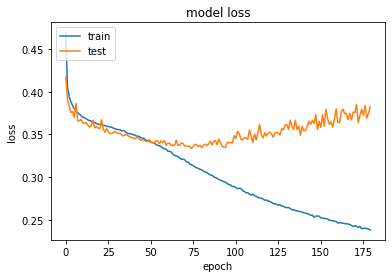

In [10]:
# summarize history for loss .3533 .8305 0.3481 0.8337
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

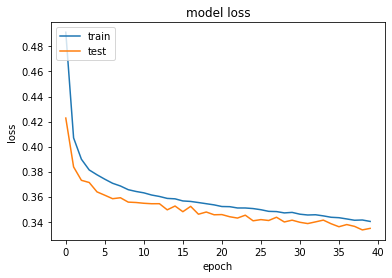

In [10]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
hitman.save("hitman_0kHz.h5")

In [12]:
#hitman=tf.keras.models.load_model("hitman_2**6_15epoch.h5", custom_objects={"hitman_trafo": hitman_trafo})

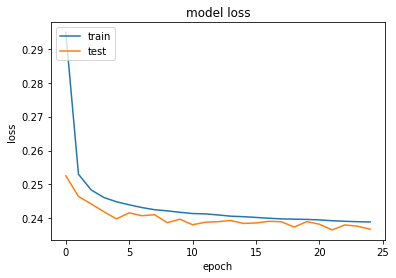

In [10]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Original:
Input:           Output:
[PMT1_1] [Event1] = 1
[PMT1_2] [Event1] = 1
-------------
[PMT2_1] [Event2] = 1
-------------
[PMT3_1] [Event1] = 1

*********************
Shuffled:
[PMT1_1] [Event3] = 0
[PMT1_2] [Event2] = 0
-------------
[PMT2_1] [Event1] = 0
-------------
[PMT3_1] [Event1] = 0

Classifier (element) [0,1]

Likelihood=1/(1-Classifier) (element) [1, infty]

[hit1][parameters]->Classifier1
[hit2][parameters]->Classifier2
.....

Likelihood function([set of PMT hits][Event_parameter])=ll_1*ll_2*...